In [4]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from itertools import cycle, islice
import h5py 

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(5)

In [2]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
data = pd.read_csv('../../datasets/HIGGS.csv.gz', header=None, names=column_names)

In [3]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [3]:
from sklearn.model_selection import train_test_split
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, train_size=0.1, test_size=0.1, random_state = 5)

In [4]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [5]:
enc = OneHotEncoder()
enc.fit(labels)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [6]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [7]:
X_good.shape, X_train.shape, X_data.shape

((1840, 6), (1886, 6), (3772, 6))

In [8]:
import tensorflow as tf

tf.set_random_seed(0)

/Users/OlgaKo/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [9]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield np.random.permutation(iterable)[ndx:min(ndx + n, l)]


In [10]:
batch_size = 128
n_epoch = 10000
N = X_data.shape[1]

In [11]:
def uniform_noise(X_good, batch_size):
    return np.random.uniform(low=np.min(X_good, axis=0), high=np.max(X_good, axis=0), size=[batch_size, X_good.shape[1]])

In [12]:
def net(X, n_hidden_1, n_hidden_2):
    layer1 = tf.layers.dense(x,n_hidden_1,tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    layer2 = tf.layers.dropout(layer1,rate=0.3)
    layer3 = tf.layers.dense(layer2,n_hidden_2,tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01))
    y = tf.layers.dense(layer1, 2, tf.nn.relu)
    return y

In [13]:
n_hidden_1 = 80
n_hidden_2 = 160

x = tf.placeholder(np.float64,shape=[None,N])
t = tf.placeholder(np.float64,shape=[None,2])
# x=tf.concat((input_batch, noise), axis=0)
# t=tf.concat((tf.zeros([batch_size, 1], tf.float64), tf.ones([batch_size, 1], tf.float64)), axis=0)
y = net(x, n_hidden_1, n_hidden_2)

predict = tf.argmax(y, axis=1)

#loss = - tf.reduce_mean(t * tf.log(y) + (1-t) * tf.log(1-y))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=t))

# regularizer = tf.contrib.layers.l2_regularizer(scale=0.01)
# reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
# reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
loss += tf.losses.get_regularization_loss()
# loss = 0.5 * tf.mean(T.nnet.softplus(-f_normal)) + \
#        0.5 * alpha * T.mean(T.nnet.softplus(f_anomalious)) + \
#        0.5 * (1 - alpha) * T.mean(T.nnet.softplus(f_noise))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [14]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
# sess.run(iterator.initializer)

for epoch in range(n_epoch):  
    for X_batch in batch(X_good, n=batch_size):
        x_val = np.concatenate((X_batch, uniform_noise(X_good, batch_size*2)))
        t_val = enc.transform(np.concatenate((np.zeros([X_batch.shape[0], 1]), np.ones([batch_size*2, 1])))).toarray()
        sess.run(train_step, feed_dict={x: x_val, 
                                        t: t_val})
        
    if epoch%100==0:
        train_accuracy = np.mean(sess.run(predict, feed_dict={x: X_bad}))
        train_loss = sess.run(loss, feed_dict={x: X_train, t: enc.transform(y_train).toarray()})
        print("Epoch = %d, train predicted annomalies = %.2f%%, train loss = %.2f"
              % (epoch , 100. * train_accuracy, 100. * train_loss))

Epoch = 0, train predicted annomalies = 93.48%, train loss = 123.82
Epoch = 100, train predicted annomalies = 67.39%, train loss = 7.58
Epoch = 200, train predicted annomalies = 54.35%, train loss = 6.28
Epoch = 300, train predicted annomalies = 60.87%, train loss = 5.29
Epoch = 400, train predicted annomalies = 63.04%, train loss = 5.65
Epoch = 500, train predicted annomalies = 60.87%, train loss = 4.60
Epoch = 600, train predicted annomalies = 73.91%, train loss = 4.66
Epoch = 700, train predicted annomalies = 84.78%, train loss = 4.14
Epoch = 800, train predicted annomalies = 80.43%, train loss = 4.66
Epoch = 900, train predicted annomalies = 71.74%, train loss = 4.40
Epoch = 1000, train predicted annomalies = 80.43%, train loss = 4.43
Epoch = 1100, train predicted annomalies = 84.78%, train loss = 3.73
Epoch = 1200, train predicted annomalies = 86.96%, train loss = 3.57
Epoch = 1300, train predicted annomalies = 82.61%, train loss = 4.34
Epoch = 1400, train predicted annomalies = 8

In [15]:
y_pred = sess.run(y, feed_dict={x: X_test})

In [16]:
print ("recall_score ",recall_score(y_test, np.argmax(y_pred, axis=1)))
print ("precision_score ",precision_score(y_test, np.argmax(y_pred, axis=1)))
print ("f1_score ",f1_score(y_test, np.argmax(y_pred, axis=1)))
print ("confusion_matrix ")
print (confusion_matrix(y_test, np.argmax(y_pred, axis=1)))

recall_score  0.914893617021
precision_score  0.614285714286
f1_score  0.735042735043
confusion_matrix 
[[1812   27]
 [   4   43]]


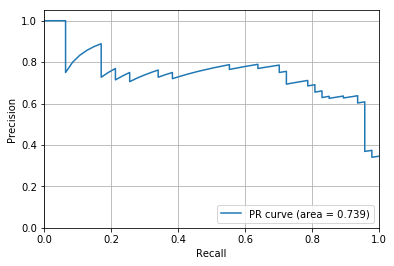

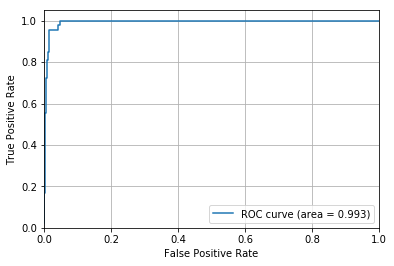

In [17]:
precision, recall, _ = precision_recall_curve(y_test, y_pred[:,1])
pr_auc = auc(recall, precision)
     

plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()